In [1]:
import os
os.chdir('../')

In [2]:
import datetime
import pickle

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from src.DRL.qnetwork import QNetwork
from src.utils import set_size_and_get_figsize
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances
from src.XAI.train_probes import get_hyperparams_combinations

In [3]:
hyperparam_ranges = {
    'lr': (0.01, 0.001, 0.0001),
    'batch_size': (64,),
    'lambda_l1': (0.0,),
    'patience': (5,),
    'epochs': (100,)
}
hyperparams = get_hyperparams_combinations(hyperparam_ranges)

In [4]:
env_steps = Concept.load_concept_data()
model_path = 'runs/20240416-095130'

def get_models(model_path):
    models = os.listdir(model_path)
    # Number of steps from file name
    models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
    # Sort on the number of steps
    models.sort(key=lambda x: x[1])
    return models

models = get_models(model_path)

In [5]:
def get_scores(concept, models, layers, hyperparams, load=False):
    scores = {'x': None, 'y': None, 'z': None}
    input_score = None

    if load:
        files = os.listdir(concept.folder_path)
        if files:
            try:
                filename = [f for f in files if f.startswith('evolution_')][0]
            except IndexError:
                return None
            with open(os.path.join(concept.folder_path, filename), 'rb') as f:
                data = pickle.load(f)
            scores = data['scores']
            print(f'Loaded scores from {filename}')
            return scores

    concept.prepare_data(env_steps, max_size=10000)
    train_steps = [m[1] for m in models]
    x, y = np.meshgrid(train_steps, [-1] + layers)  # Include -1 for input score layer
    scores['x'] = x
    scores['y'] = y
    scores['z'] = np.zeros((len(layers) + 1, len(train_steps)))

    for step_index, step in enumerate(train_steps):
        path = os.path.join(model_path, f'model_{step}.pt')
        model = QNetwork(model_path=path)
        if input_score is None:
            # Only compute input score once for the first model
            _, layer_info, _ = train_probes(model, concept, hyperparams, [-1])
            input_score = layer_info[-1]['test_score'][-1]

        # Compute scores for all layers
        _, layer_info, _ = train_probes(model, concept, hyperparams, layers)
        scores['z'][0][step_index] = input_score
        for layer_index, layer in enumerate(layers):
            scores['z'][layer_index + 1][step_index] = layer_info[layer]['test_score'][-1]
    
    # Save the scores
    evolution_filename = f'evolution_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
    evolution_path = os.path.join(concept.folder_path, evolution_filename)
    with open(evolution_path, 'wb') as f:
        pickle.dump({'scores': scores}, f)

    return scores

In [6]:
def plot_evolution(concept, scores):
    # fig = plt.figure(figsize=set_size_and_get_figsize(2.5))
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.text2D(0.5, 0.9, f'{concept.plot_name}', transform=ax.transAxes, ha='center', fontsize=30)
    ax.view_init(elev=25, azim=190)
    
    ax.plot_surface(np.log10(scores['x']+1), scores['y'], np.maximum(0.001, scores['z']), vmin=0, vmax=1, cmap='plasma')
    ax.set_xlabel('Checkpoint', labelpad=15, fontsize=22)
    ax.xaxis.set_tick_params(pad=10, labelsize=15)
    ax.set_xticks(np.log10([1, 10**2, 10**4, 10**6]))
    ax.set_xticklabels(['$0$', '$10^2$', '$10^4$', '$10^6$'])
    for tick in ax.get_xticklabels():
        tick.set_verticalalignment('bottom')
    
    ax.set_ylabel('Layer', labelpad=10, fontsize=22)
    ax.set_yticks(np.unique(scores['y']))
    ytick_labels = [str(int(y)+1) for y in np.unique(scores['y'])] # plus 1 to start at 0 and not -1 to respect notation
    ax.set_yticklabels(ytick_labels)
    ax.yaxis.set_tick_params(pad=5, labelsize=15)

    ax.set_zlabel('Score', labelpad=10, fontsize=22)
    ax.set_zticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.zaxis.set_tick_params(pad=5, labelsize=15)

    plt.savefig(f'figures/concept evolution/{concept.name}.png', bbox_inches='tight', pad_inches=0.35)
    plt.show()

Loaded scores from evolution_20240418-131410.pkl


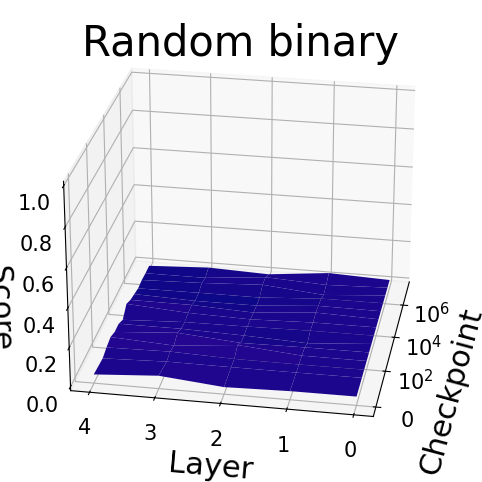

Loaded scores from evolution_20240418-132959.pkl


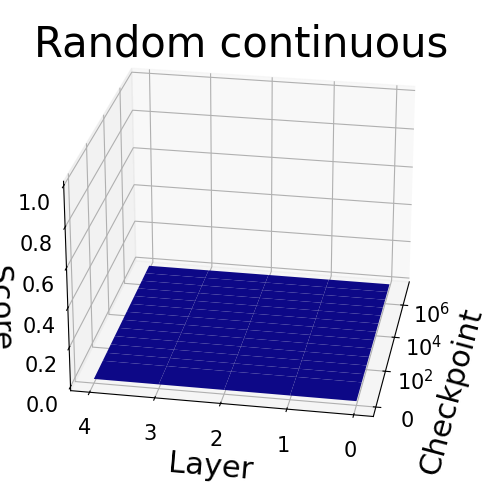

Loaded scores from evolution_20240418-155941.pkl


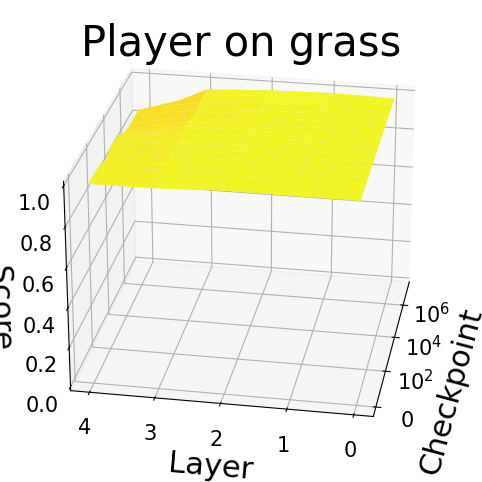

Loaded scores from evolution_20240418-232329.pkl


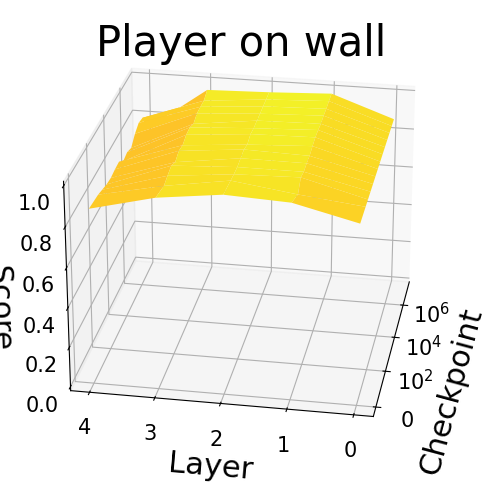

Loaded scores from evolution_20240418-183001.pkl


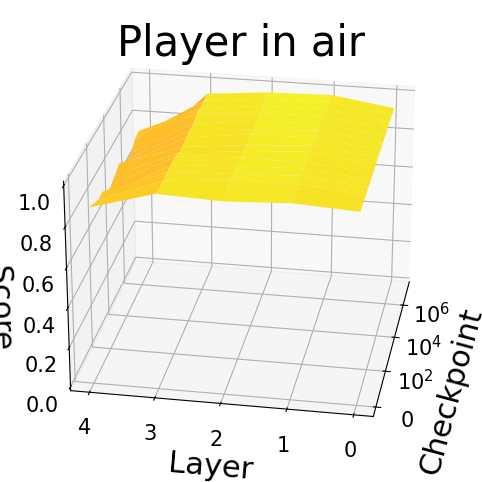

Loaded scores from evolution_20240418-211246.pkl


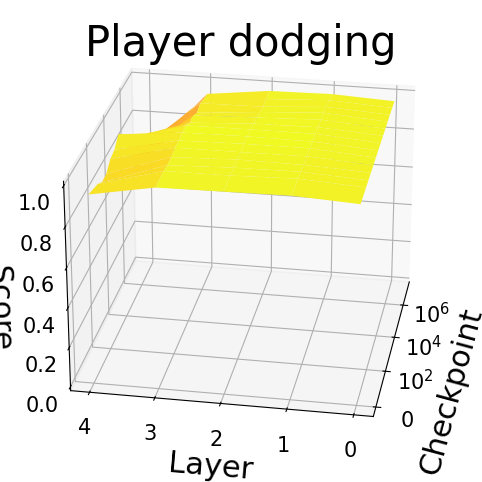

Loaded scores from evolution_20240418-235844.pkl


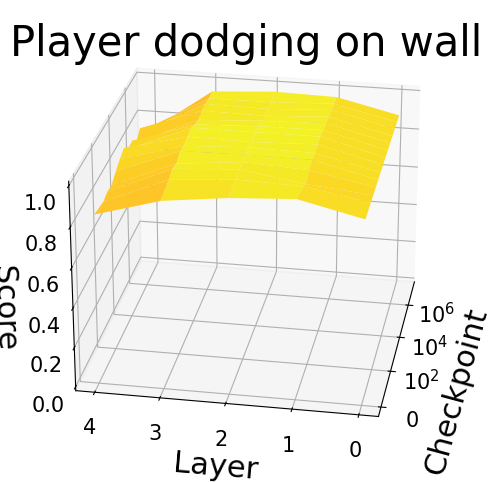

Loaded scores from evolution_20240419-005513.pkl


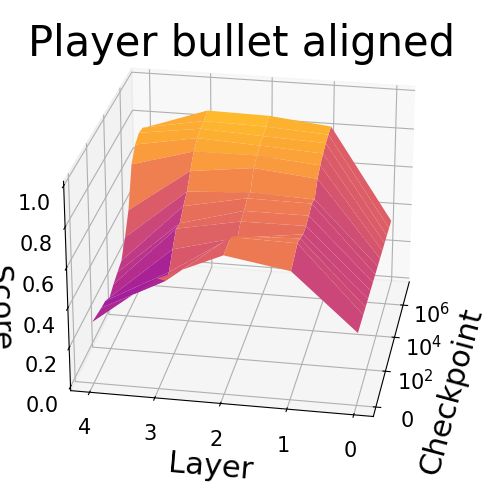

Loaded scores from evolution_20240419-021324.pkl


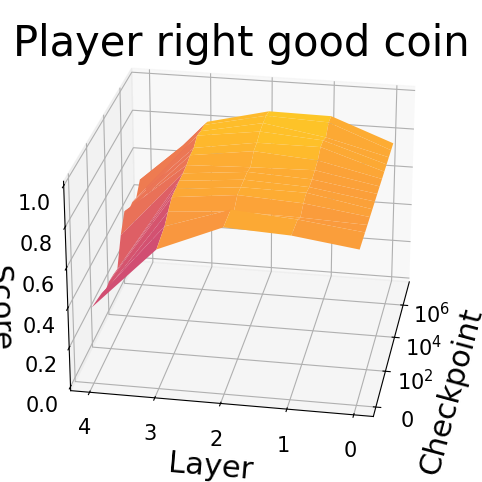

Loaded scores from evolution_20240419-030628.pkl


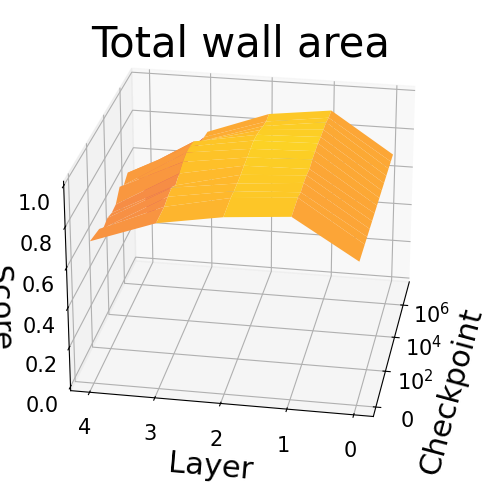

Loaded scores from evolution_20240419-082549.pkl


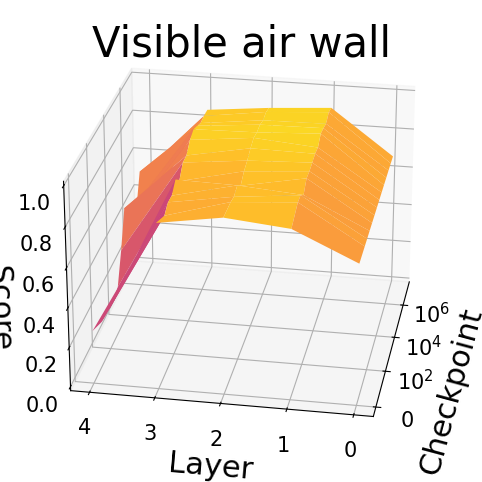

Loaded scores from evolution_20240419-065958.pkl


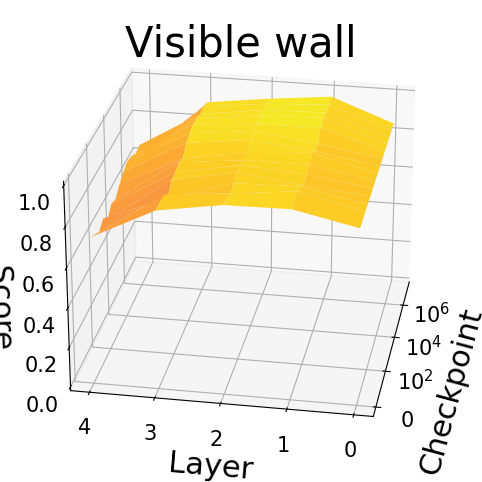

Loaded scores from evolution_20240419-092446.pkl


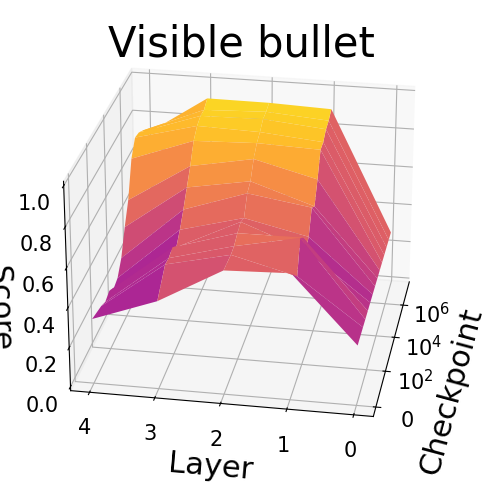

Loaded scores from evolution_20240419-110238.pkl


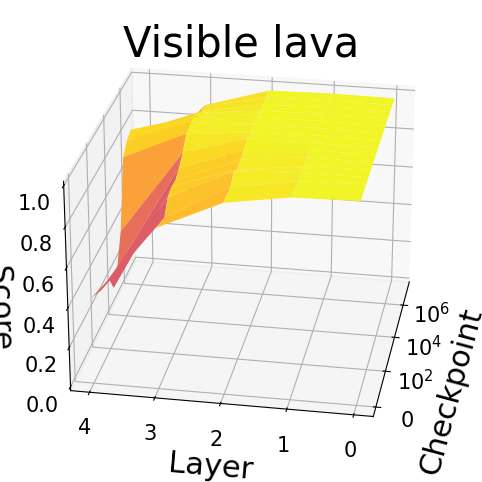

Loaded scores from evolution_20240419-122135.pkl


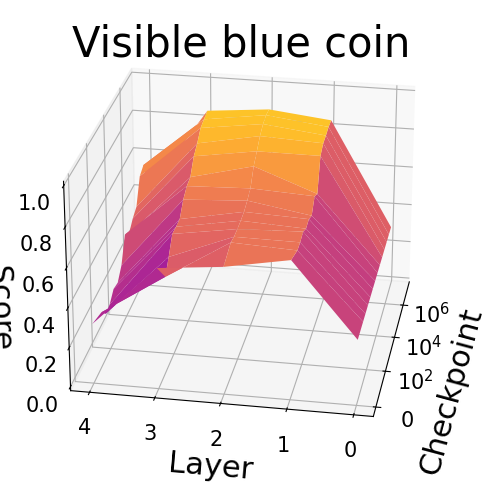

Loaded scores from evolution_20240419-132131.pkl


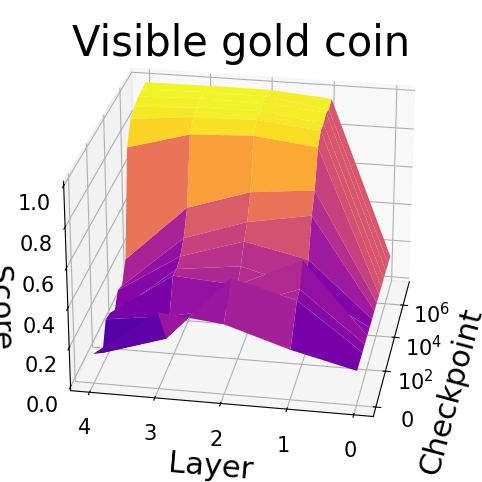

Loaded scores from evolution_20240419-134555.pkl


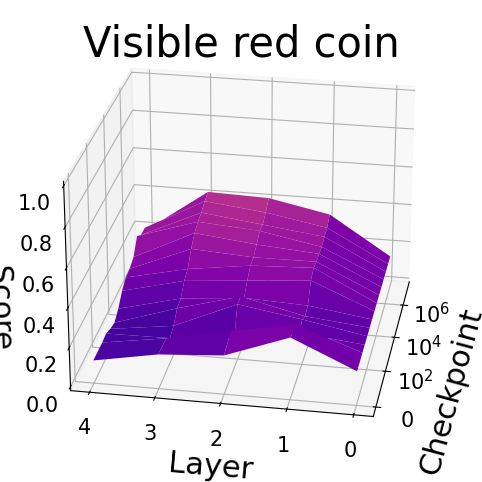

Loaded scores from evolution_20240419-155006.pkl


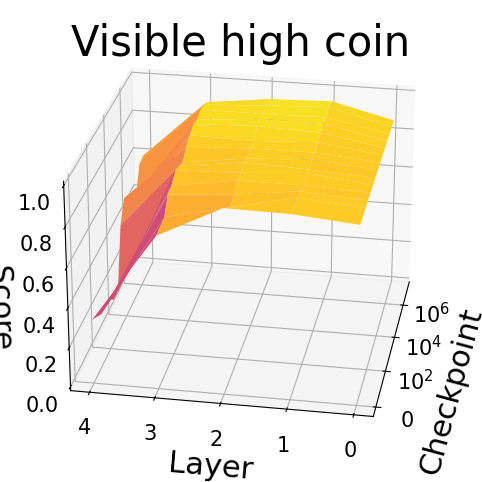

Loaded scores from evolution_20240419-164945.pkl


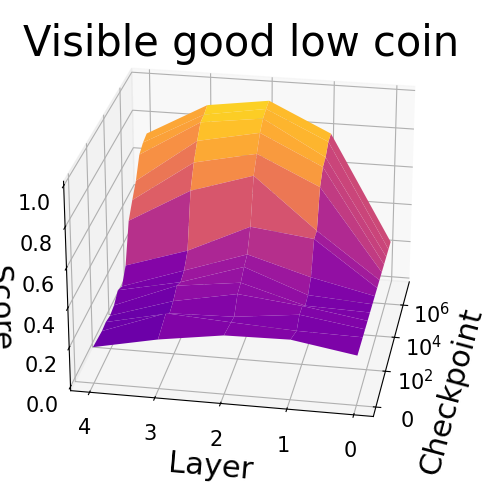

Loaded scores from evolution_20240419-035025.pkl


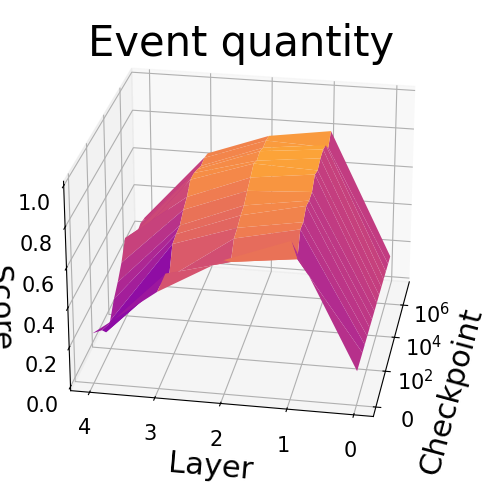

Loaded scores from evolution_20240419-043114.pkl


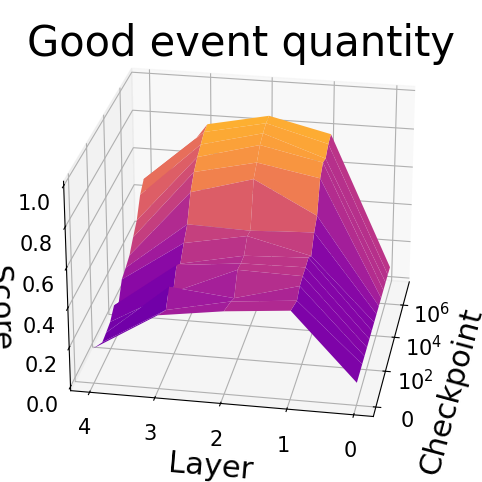

Loaded scores from evolution_20240419-051950.pkl


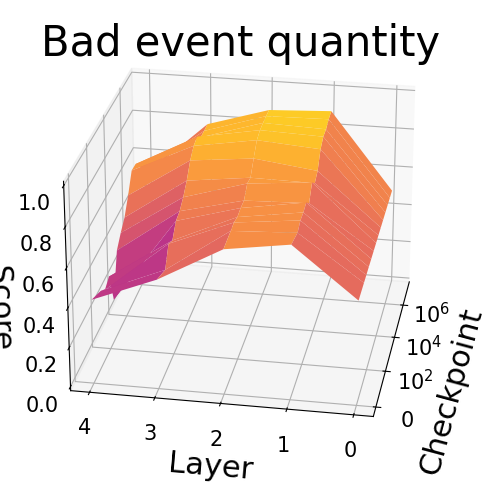

In [7]:
for concept in concept_instances.values():
    scores = get_scores(concept, models, [0, 1, 2, 3, 4, 5, 6, 7, 8], hyperparams, load=True)
    if not scores:
        continue
    # remove layers
    indices_to_remove = [1, 3, 5, 7, 8]
    scores['x'] = np.delete(scores['x'], indices_to_remove, axis=0)
    scores['y'] = np.delete(scores['y'], indices_to_remove, axis=0)
    scores['z'] = np.delete(scores['z'], indices_to_remove, axis=0)
    # Rename layers
    for i in range(len(scores['y'])):
        scores['y'][i] = np.array([i-1] * len(scores['y'][i]))
    plot_evolution(concept, scores)

In [8]:
final_scores = {}
for concept in concept_instances.values():
    if 'random' in concept.name:
        continue
    scores = get_scores(concept, models, [0, 1, 2, 3, 4, 5, 6, 7, 8], hyperparams, load=True)
    if not scores:
        continue
    
    final_scores[concept.plot_name] = [scores['z'][0][-1],
                                    scores['z'][2][-1],
                                    scores['z'][4][-1],
                                    scores['z'][6][-1],
                                    scores['z'][9][-1]]

Loaded scores from evolution_20240418-155941.pkl
Loaded scores from evolution_20240418-232329.pkl
Loaded scores from evolution_20240418-183001.pkl
Loaded scores from evolution_20240418-211246.pkl
Loaded scores from evolution_20240418-235844.pkl
Loaded scores from evolution_20240419-005513.pkl
Loaded scores from evolution_20240419-021324.pkl
Loaded scores from evolution_20240419-030628.pkl
Loaded scores from evolution_20240419-082549.pkl
Loaded scores from evolution_20240419-065958.pkl
Loaded scores from evolution_20240419-092446.pkl
Loaded scores from evolution_20240419-110238.pkl
Loaded scores from evolution_20240419-122135.pkl
Loaded scores from evolution_20240419-132131.pkl
Loaded scores from evolution_20240419-134555.pkl
Loaded scores from evolution_20240419-155006.pkl
Loaded scores from evolution_20240419-164945.pkl
Loaded scores from evolution_20240419-035025.pkl
Loaded scores from evolution_20240419-043114.pkl
Loaded scores from evolution_20240419-051950.pkl


/tmp/ipykernel_5646/907201378.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(final_scores.keys()))


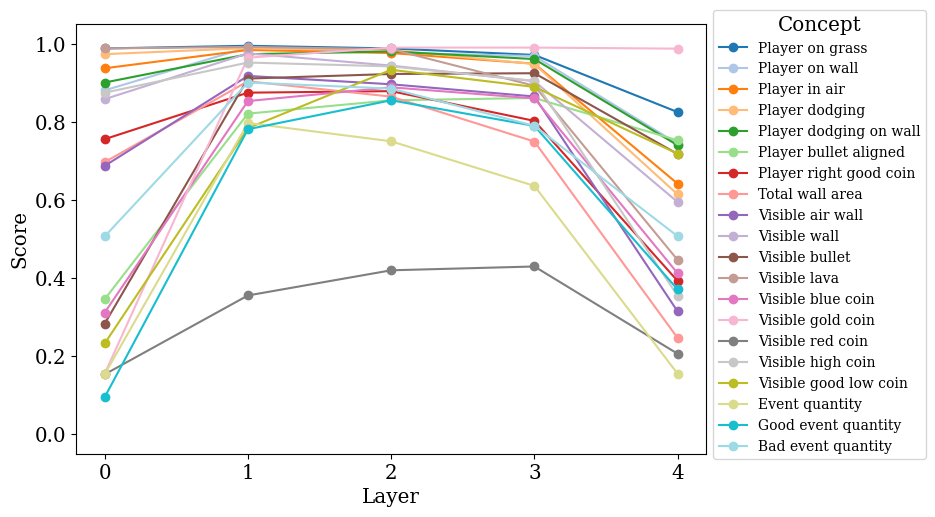

In [9]:
actual_layers = [0, 1, 2, 3, 4]

fig, ax = plt.subplots(figsize=set_size_and_get_figsize(0.8))
cmap = cm.get_cmap('tab20', len(final_scores.keys()))

# Iterate through concepts and plot each with a unique color from the colormap
for i, (concept, concept_scores) in enumerate(final_scores.items()):
    color = cmap(i)
    ax.plot(actual_layers, concept_scores, marker='o', label=concept, color=color)

ax.set_xlabel('Layer')
ax.set_xticks(actual_layers)
ax.set_ylabel('Score')
ax.set_ylim([-0.05, 1.05])

# Placing the legend outside the plot
ax.legend(title="Concept", loc='upper left', bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.savefig('figures/concept evolution/concept scores.png')
plt.show()

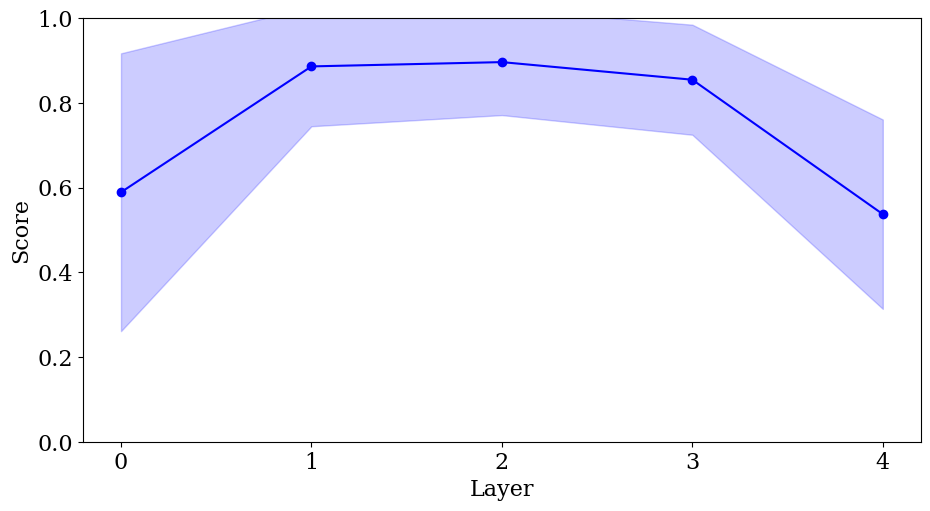

In [10]:
mean_scores = []
std_scores = []

for i in range(len(actual_layers)):
    layer_scores = [final_scores[concept][i] for concept in final_scores]
    mean_scores.append(np.mean(layer_scores))
    std_scores.append(np.std(layer_scores))

# Plotting the mean scores with standard deviation shading
fig, ax = plt.subplots(figsize=set_size_and_get_figsize(1))

ax.plot(actual_layers, mean_scores, marker='o', color='blue', label='Mean Score')
ax.fill_between(actual_layers, np.array(mean_scores) - np.array(std_scores), np.array(mean_scores) + np.array(std_scores), color='blue', alpha=0.2)

ax.set_xlabel('Layer')
ax.set_xticks(actual_layers)
ax.set_ylabel('Score')
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('figures/concept evolution/mean concept scores.png')
plt.show()